In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon
from scipy.stats import poisson, geom

In [14]:
sample = "mm34"

reference = pd.read_csv(rf'../data/input_data/{sample}/ref.csv', index_col=0)
alternative = pd.read_csv(rf'../data/input_data/{sample}/alt.csv', index_col=0)

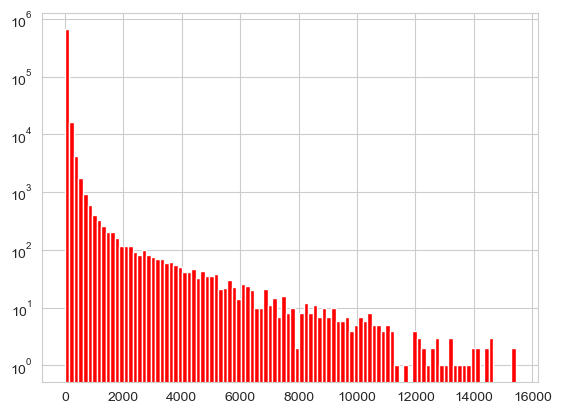

In [15]:
coverage = reference.fillna(0) + alternative.fillna(0)

cov_flattened = coverage.values.flatten()

plt.hist(cov_flattened, bins=100, color= "red")
plt.yscale('log')
plt.show()

In [16]:
# An optimized ZINB distribution fits the data well, up to about a coverage of 1000

def sample_zinb(mu, theta, pi, size):
    """
    Samples synthetic data from the learned ZINB distribution.
    
    Args:
        mu: Mean of the Negative Binomial.
        theta: Dispersion parameter of the Negative Binomial.
        pi: Zero-inflation probability.
        size: Number of samples to generate.
    
    Returns:
        A numpy array of sampled data.
    """
    nb_samples = nbinom.rvs(theta, theta / (theta+ mu), size=size)
    zero_inflation_mask = np.random.rand(size) < pi
    samples = np.where(zero_inflation_mask, 0, nb_samples)
    return samples

mu, theta, pi =  248.86570739746094, 0.31441208720207214, 0.4835776686668396

synthetic_data = sample_zinb(mu, theta, pi, size=len(cov_flattened))

bin_width=40
min_value = min(cov_flattened.min(), synthetic_data.min())
max_value = max(cov_flattened.max(), synthetic_data.max())
bin_edges = np.arange(min_value, max_value + bin_width, bin_width)

plt.hist(cov_flattened, bins=100, color= "red")
plt.hist(synthetic_data, bins=100, color="blue", alpha=0.5)
plt.yscale('log')
plt.show()

plt.hist(cov_flattened, bins=bin_edges, color= "red")
plt.hist(synthetic_data, bins=bin_edges, color="blue", alpha=0.5)
plt.yscale('log')
plt.xlim([0, 2000])
plt.show()

NameError: name 'nbinom' is not defined

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from scipy.stats import nbinom

# Example RNA-like read count data (replace with your own data)
np.random.seed(42)
# data_counts = np.random.negative_binomial(n=10, p=0.5, size=500)  # Negative Binomial distributed data
# data_counts[np.random.choice(len(data_counts), 100, replace=False)] = 0  # Add excess zeros
data_counts = cov_flattened

# Convert data to PyTorch tensors
counts = torch.tensor(data_counts, dtype=torch.float32)
covariates = torch.ones((len(data_counts), 1), dtype=torch.float32)

# Create DataLoader
dataset = TensorDataset(counts, covariates)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


# Define the ZINB Model
class ZINBModel(nn.Module):
    def __init__(self, input_dim):
        super(ZINBModel, self).__init__()
        self.fc = nn.Linear(input_dim, 3)  # Outputs: log_mu, log_theta, logit_pi

    def forward(self, x):
        params = self.fc(x)
        log_mu = params[:, 0]
        log_theta = params[:, 1]
        logit_pi = params[:, 2]
        mu = torch.exp(log_mu)
        theta = torch.exp(log_theta)
        pi = torch.sigmoid(logit_pi)
        return mu, theta, pi

# ZINB Loss Function
def zinb_loss(y, mu, theta, pi):
    """
    Compute the ZINB loss for the given data and parameters.

    Args:
        y: Observed counts (tensor)
        mu: Mean of the negative binomial (tensor)
        theta: Dispersion parameter (tensor)
        pi: Zero-inflation probability (tensor)
    """
    eps = 1e-10  # To avoid log(0)
    
    # Log-likelihood for negative binomial
    log_nb = (
        torch.lgamma(theta + y) 
        - torch.lgamma(theta)
        - torch.lgamma(y + 1)
        + theta * torch.log(theta + eps)
        + y * torch.log(mu + eps)
        - (theta + y) * torch.log(theta + mu + eps)
    )
    
    # Log-likelihood for zero-inflation
    log_zero_infl = torch.log(pi + (1 - pi) * torch.exp(log_nb))
    log_non_zero = torch.log(1 - pi + eps) + log_nb

    weights = torch.sqrt(y / y.mean()) # weigh outliers higher
    log_non_zero = weights * log_non_zero
    
    log_likelihood = torch.where(y < 1, log_zero_infl, log_non_zero)
    
    return -torch.mean(log_likelihood)

# Training the Model
model = ZINBModel(input_dim=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 50

for epoch in range(epochs):
    print(epoch)
    total_loss = 0
    for batch_counts, batch_covariates in dataloader:
        # Forward pass
        mu, theta, pi = model(batch_covariates)
        
        # Compute loss
        loss = zinb_loss(batch_counts, mu, theta, pi)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    if (epoch + 1) % 1 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(dataloader):.4f}")
        with torch.no_grad():
            mu, theta, pi = model(covariates)
        mu_mean = mu.mean().item()
        theta_mean = theta.mean().item()
        pi_mean = pi.mean().item()
        print(f"Global Mu: {mu_mean}, Global Theta: {theta_mean}, Global Pi: {pi_mean}")

In [ ]:
mu_mean=60
theta_mean=0.17
pi_mean=0.38


custom_mu = torch.full_like(counts, fill_value=mu_mean)  # Custom constant mu
custom_theta = torch.full_like(counts, fill_value=theta_mean)  # Custom constant theta
custom_pi = torch.full_like(counts, fill_value=pi_mean)  # Custom constant pi

# Calculate ZINB loss for the full dataset with custom parameters
custom_loss = zinb_loss(counts, custom_mu, custom_theta, custom_pi).item()

# Calculate ZINB loss for the full dataset with optimized parameters
with torch.no_grad():
    optimized_mu, optimized_theta, optimized_pi = model(covariates)
    optimized_loss = zinb_loss(counts, optimized_mu, optimized_theta, optimized_pi).item()

# Print the losses for comparison
print(f"Custom Loss: {custom_loss:.4f}")
print(f"Optimized Loss: {optimized_loss:.4f}")

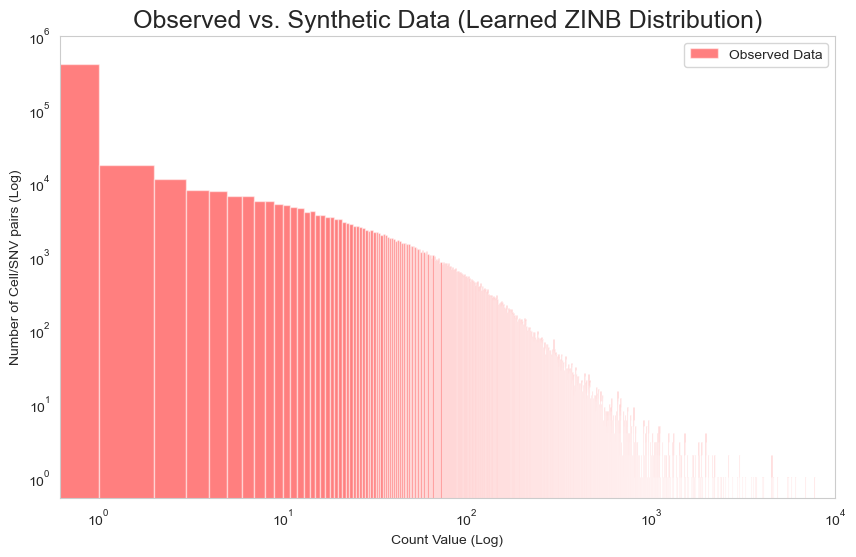

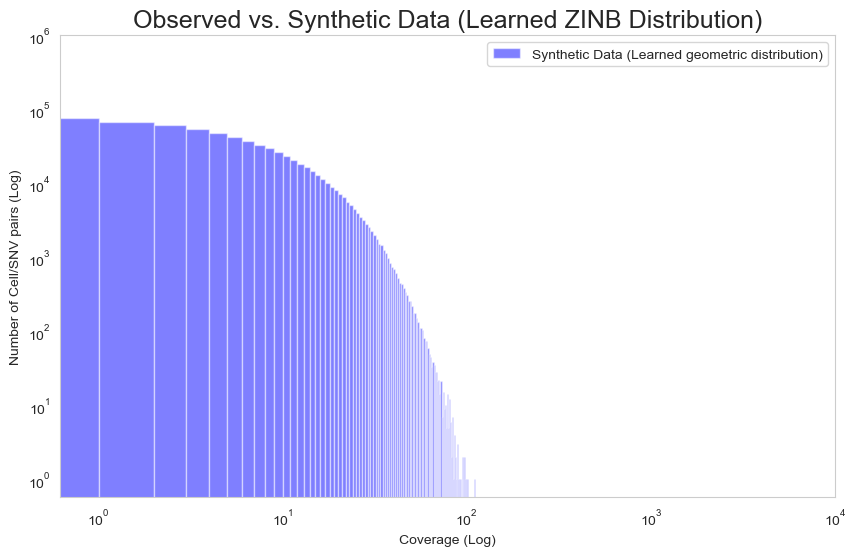

In [18]:
# 63.52058029174805, Global Theta: 0.16909955441951752, Global Pi: 0.371642529964447
# 59.354854583740234, 0.16244009137153625, 0.4019698202610016

mu, theta, pi = 60, 0.17, 0.38

synthetic_data = sample_zinb(mu, theta, pi, size=len(cov_flattened))
# synthetic_data = geom.rvs(p=1/9, loc=-1, size=len(cov_flattened))

# Visualization of Observed vs. Synthetic Data

bin_width = 1  # Replace with the desired bin width

data_counts = cov_flattened
# Calculate the bin edges based on the range of the data
min_value = min(data_counts.min(), synthetic_data.min())
max_value = max(data_counts.max(), synthetic_data.max())
bin_edges = np.arange(min_value, max_value + bin_width, bin_width)

plt.figure(figsize=(10, 6))
# Plot observed data as histogram
plt.hist(data_counts, bins=bin_edges, alpha=0.5, color='red', label="Observed Data")
# Add labels and legend
plt.xlabel("Count Value (Log)")
plt.ylabel("Number of Cell/SNV pairs (Log)")
plt.title("Observed vs. Synthetic Data (Learned ZINB Distribution)", fontsize=18)
plt.legend()
plt.yscale("log")
plt.grid(False)
plt.xscale("log")
plt.ylim(None,1000000)
plt.xlim(None,10000)
plt.show()

plt.figure(figsize=(10, 6))
# Plot synthetic data as histogram
plt.hist(synthetic_data, bins=bin_edges, alpha=0.5, color='blue', label="Synthetic Data (Learned ZINB)")

# Add labels and legend
plt.xlabel("Coverage (Log)")
plt.ylabel("Number of Cell/SNV pairs (Log)")
plt.title("Observed vs. Synthetic Data (Learned ZINB Distribution)", fontsize=18)
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.grid(False)
plt.ylim(None,1000000)
plt.xlim(None,10000)
plt.show()

In [ ]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import chi2
import numpy as np
from scipy.stats import poisson, norm, beta
from scipy.special import beta as beta_func

def gauss_quad(n, alpha, beta):
    """
    Gaussian quadrature for Jacobi polynomials with specified alpha and beta.
    """
    from numpy.polynomial.legendre import leggauss
    x, w = leggauss(n)
    # Transform weights and nodes for Jacobi polynomial
    x = (x + 1) / 2  # Scale to [0, 1]
    w = w * (2 ** (alpha + beta + 1)) / beta_func(alpha + 1, beta + 1)
    return x, w

def fn3(x1, x2, m):
    """
    Compute the interval probability: P(x1 < X <= x2)
    for a given mean m using Poisson or Normal approximation.
    """
    if np.max(m) < 100000:
        # Use Poisson CDF for small m
        return poisson.cdf(x2, m) - poisson.cdf(x1, m)
    else:
        # Use Normal approximation for large m
        return norm.cdf(x2, loc=m, scale=np.sqrt(m)) - norm.cdf(x1, loc=m, scale=np.sqrt(m))

def pBPi(x1, x2, alp, bet, lam1=1, lam2=1):
    """
    Compute the probability distribution function (PDF) of an interval
    from a four-parameter beta-Poisson model.
    
    Parameters:
    - x1: Lower bound of the interval
    - x2: Upper bound of the interval
    - alp: Parameter of Beta function (alpha)
    - bet: Parameter of Beta function (beta)
    - lam1: Parameter for scaling
    - lam2: Parameter for smoothing
    
    Returns:
    - Probability of the interval
    """
    # Rescale x1 and x2 using lam2
    x1 = x1 / lam2
    x2 = x2 / lam2
    
    # Perform Gaussian quadrature
    nodes, weights = gauss_quad(10, bet - 1, alp - 1)
    
    # Compute the sum over Gaussian quadrature nodes and weights
    gs = np.sum(weights * fn3(x1, x2, m=lam1 * (1 + nodes) / 2))
    
    # Compute the probability
    prob = (1 / beta_func(alp, bet)) * (2 ** (-alp - bet + 1)) * gs
    return prob

# Define loss functions for optimization
def ff3(params, y, n, tbreak):
    alpha, beta, lambda1 = params
    if any(p < 0 for p in params) or alpha > 1e3 or beta > 1e3:
        return 1e10
    bp_y = np.array([n * pBPi(tbreak[i], tbreak[i+1], alpha, beta, lambda1) for i in range(len(tbreak)-1)])
    bp_y = np.abs(bp_y)
    valid_indices = bp_y > 0
    esp_val_E = 1e-6
    return 2 * np.sum(y[valid_indices] * np.log(y[valid_indices] / (bp_y[valid_indices] + esp_val_E)))

def ff4(params, y, n, tbreak):
    alpha, beta, lambda1, lambda2 = params
    if any(p < 0 for p in params) or alpha > 1e3 or beta > 1e3:
        return 1e10
    bp_y = np.array([n * pBPi(tbreak[i], tbreak[i+1], alpha, beta, lambda1, lambda2) for i in range(len(tbreak)-1)])
    bp_y = np.abs(bp_y)
    valid_indices = bp_y > 0
    esp_val_E = 1e-6
    return 2 * np.sum(y[valid_indices] * np.log(y[valid_indices] / (bp_y[valid_indices] + esp_val_E)))

def ff5(params, y, n, tbreak):
    alpha, beta, lambda1, lambda2, prob0 = params
    if any(p < 0 for p in params) or alpha > 1e3 or beta > 1e3 or prob0 > 1:
        return 1e10
    dens = np.array([pBPi(tbreak[i], tbreak[i+1], alpha, beta, lambda1, lambda2) for i in range(len(tbreak)-1)])
    bp_y = (n - round(prob0 * n)) * dens
    bp_y[0] += round(prob0 * n)
    bp_y = np.abs(bp_y)
    valid_indices = bp_y > 0
    esp_val_E = 1e-6
    return 2 * np.sum(y[valid_indices] * np.log(y[valid_indices] / (bp_y[valid_indices] + esp_val_E)))

# Main function to estimate beta-Poisson parameters
def estimateBP(x, para_num=4, tbreak_num=10, break_thres=10, use_ext=False, param0=None):
    # Helper to create bins
    def getTbreak(x, tbreak_num, break_thres, use_ext):
        return np.linspace(min(x), max(x), tbreak_num+1)

    # Binning the data
    tbreak = getTbreak(x, tbreak_num, break_thres, use_ext)
    y, _ = np.histogram(x, bins=tbreak)
    n = np.sum(y)

    # Define initial parameters if not provided
    if param0 is None:
        param0 = np.random.uniform(0.5, 1.5, para_num)  # Replace with a proper initialization

    # Select the loss function based on the number of parameters
    if para_num == 3:
        loss_fn = ff3
    elif para_num == 4:
        loss_fn = ff4
    elif para_num == 5:
        loss_fn = ff5
    else:
        raise ValueError("para_num must be 3, 4, or 5")

    # Run optimization
    result = minimize(loss_fn, param0, args=(y, n, tbreak), method='L-BFGS-B', options={'disp': True})

    # Compute goodness-of-fit and additional metrics
    if result.success:
        X2 = result.fun
        df = len(y) - 1 - len(param0)
        PVAL = chi2.sf(X2, df)
        AIC = 2 * len(param0) + X2
        return {
            "par": result.x,
            "X2": X2,
            "df": df,
            "PVAL": PVAL,
            "AIC": AIC,
            "tbreak": tbreak,
            "y": y,
            "param0": param0,
            "prop0": np.sum(x == 0) / len(x)
        }
    else:
        return {
            "par": None,
            "X2": None,
            "df": None,
            "PVAL": None,
            "AIC": None,
            "tbreak": tbreak,
            "y": y,
            "param0": param0,
            "prop0": np.sum(x == 0) / len(x)
        }

# Example usage
np.random.seed(2015)
alp, bet, lam1, lam2 = 0.6, 1.5, 20, 0.05
param0 = [alp, bet, lam1, lam2]
bp_vec = np.random.beta(alp, bet, 100) * np.random.poisson(lam1, 100)  # Simulated data
result = estimateBP(bp_vec, para_num=4)
print(result)

In [ ]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import chi2
from scipy.stats import poisson, norm, beta
from scipy.special import beta as beta_func
import matplotlib.pyplot as plt

def gauss_quad(n, alpha, beta):
    """
    Gaussian quadrature for Jacobi polynomials with specified alpha and beta.
    """
    from numpy.polynomial.legendre import leggauss
    x, w = leggauss(n)
    # Transform weights and nodes for Jacobi polynomial
    x = (x + 1) / 2  # Scale to [0, 1]
    w = w * (2 ** (alpha + beta + 1)) / beta_func(alpha + 1, beta + 1)
    return x, w

def fn3(x1, x2, m):
    """
    Compute the interval probability: P(x1 < X <= x2)
    for a given mean m using Poisson or Normal approximation.
    """
    if np.max(m) < 100000:
        # Use Poisson CDF for small m
        return poisson.cdf(x2, m) - poisson.cdf(x1, m)
    else:
        # Use Normal approximation for large m
        return norm.cdf(x2, loc=m, scale=np.sqrt(m)) - norm.cdf(x1, loc=m, scale=np.sqrt(m))

def pBPi(x1, x2, alp, bet, lam1=1, lam2=1):
    """
    Compute the probability distribution function (PDF) of an interval
    from a four-parameter beta-Poisson model.
    
    Parameters:
    - x1: Lower bound of the interval
    - x2: Upper bound of the interval
    - alp: Parameter of Beta function (alpha)
    - bet: Parameter of Beta function (beta)
    - lam1: Parameter for scaling
    - lam2: Parameter for smoothing
    
    Returns:
    - Probability of the interval
    """
    # Rescale x1 and x2 using lam2
    x1 = x1 / lam2
    x2 = x2 / lam2
    
    # Perform Gaussian quadrature
    nodes, weights = gauss_quad(10, bet - 1, alp - 1)
    
    # Compute the sum over Gaussian quadrature nodes and weights
    gs = np.sum(weights * fn3(x1, x2, m=lam1 * (1 + nodes) / 2))
    
    # Compute the probability
    prob = (1 / beta_func(alp, bet)) * (2 ** (-alp - bet + 1)) * gs
    return prob

# Define loss functions for optimization
def ff5(params, y, n, tbreak):
    alpha, beta, lambda1, lambda2, prob0 = params
    if any(p < 0 for p in params) or alpha > 1e3 or beta > 1e3 or prob0 > 1:
        return 1e10
    dens = np.array([pBPi(tbreak[i], tbreak[i+1], alpha, beta, lambda1, lambda2) for i in range(len(tbreak)-1)])
    bp_y = (n - round(prob0 * n)) * dens
    bp_y[0] += round(prob0 * n)
    bp_y = np.abs(bp_y)
    valid_indices = bp_y > 0
    esp_val_E = 1e-6
    return 2 * np.sum(y[valid_indices] * np.log(y[valid_indices] / (bp_y[valid_indices] + esp_val_E)))

# Main function to estimate beta-Poisson parameters
def estimateBP(x, para_num=5, tbreak_num=10, break_thres=10, use_ext=False, param0=None):
    # Helper to create bins
    def getTbreak(x, tbreak_num, break_thres, use_ext):
        return np.linspace(min(x), max(x), tbreak_num+1)

    # Binning the data
    tbreak = getTbreak(x, tbreak_num, break_thres, use_ext)
    y, _ = np.histogram(x, bins=tbreak)
    n = np.sum(y)

    # Define initial parameters if not provided
    if param0 is None:
        param0 = np.random.uniform(0.5, 1.5, para_num)  # Replace with a proper initialization

    # Select the loss function for 5 parameters
    loss_fn = ff5

    # Run optimization
    result = minimize(loss_fn, param0, args=(y, n, tbreak), method='L-BFGS-B', options={'disp': True})

    # Compute goodness-of-fit and additional metrics
    if result.success:
        X2 = result.fun
        df = len(y) - 1 - len(param0)
        PVAL = chi2.sf(X2, df)
        AIC = 2 * len(param0) + X2
        return {
            "par": result.x,
            "X2": X2,
            "df": df,
            "PVAL": PVAL,
            "AIC": AIC,
            "tbreak": tbreak,
            "y": y,
            "param0": param0,
            "prop0": np.sum(x == 0) / len(x)
        }
    else:
        return {
            "par": None,
            "X2": None,
            "df": None,
            "PVAL": None,
            "AIC": None,
            "tbreak": tbreak,
            "y": y,
            "param0": param0,
            "prop0": np.sum(x == 0) / len(x)
        }

# Simulate a dataset with known parameters
np.random.seed(42)
alp, bet, lam1, lam2, prob0 = 0.8, 2.0, 15, 0.1, 0.05
n = 1000
beta_samples = np.random.beta(alp, bet, n)
poisson_samples = np.random.poisson(lam1 * beta_samples / lam2, n)
simulated_data = poisson_samples

# Estimate parameters
param0 = [alp, bet, lam1, lam2, prob0]
result = estimateBP(simulated_data, para_num=5, param0=param0)
print("Fitted Parameters:", result["par"])

# Generate a sample using the fitted parameters
fitted_params = result["par"]
alpha_fit, beta_fit, lambda1_fit, lambda2_fit, prob0_fit = fitted_params
beta_samples_fit = np.random.beta(alpha_fit, beta_fit, n)
poisson_samples_fit = np.random.poisson(lambda1_fit * beta_samples_fit / lambda2_fit, n)
generated_data = poisson_samples_fit

# Compare histograms
plt.figure(figsize=(12, 6))
plt.hist(simulated_data, bins=20, alpha=0.5, label="Simulated Data (True Params)")
plt.hist(generated_data, bins=20, alpha=0.5, label="Generated Data (Fitted Params)")
plt.legend()
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Comparison of Simulated and Generated Data")
plt.show()

In [ ]:
#' Estimate parameters of beta-Poisson models for a data matrix
#'
#' @param dataMat Data matrix that needs to be modelled
#' @param para.num Mode of beta-Poisson model: 3, 4 (default) or 5 parameters
#' @param tbreak.num Number of breaks for binning
#' @param fout A *.RData file name to export results
#' @param break.thres A parameter setting of \code{\link{getTbreak}} function
#' @param estIntPar An option to allow estimating initial parameters for the model from only expressed values
#' @param extreme.quant A quantile probability to remove extreme values (outliers) higher than the quantile. If extreme.quant=NULL, no elimination of outliers is done
#' @param useExt A parameter setting of \code{\link{getTbreak}} function that allows to extend the last bin to infinity or not
#' @param min.exp A threshold for minimum expressed values. If an expression is less than min.exp, it is set to be zero
#' @param useParallel An option to allow using parallel computing
#' @return A list of optimal models corresponding to the rows of the matrix. Each model consists of optimal parameters, X2 test results (X2 and PVAL), etc.
#' @export
#' @importFrom doParallel registerDoParallel
#' @importFrom foreach foreach
#' @importFrom foreach %dopar%
#' @examples
#' set.seed(2015)
#' # Create random data matrix from a beta-Poisson model
#' N=10
#' alp=sample(100,N,replace=TRUE)*0.1
#' bet=sample(100,N,replace=TRUE)*0.1
#' lam1=sample(100,N,replace=TRUE)*10
#' lam2=sample(100,N,replace=TRUE)*0.01
#' n=100
#' bp.mat=NULL
#' for (i in 1:N)
#'   bp.mat=rbind(bp.mat,rBP(n,alp=alp[i],bet=bet[i],lam1=lam1[i],lam2=lam2[i]))
#' # Estimate parameters from the data set
#' mat.res=estimateBPMatrix(bp.mat,para.num=4,fout=NULL,estIntPar=FALSE,useParallel=FALSE)
#' # In this function, user can also set estIntPar=TRUE to have better estimated beta-Poisson 
#' # models for the generalized linear model. However, a longer computational time is required.

def estimateBPMatrix(dataMat, para_num=4, tbreak_num=10, fout=None, break_thres=10, estIntPar=True, extreme_quant=None, useExt=False, min_exp=1e-4, useParallel=False):
    """
    Estimate parameters of beta-Poisson models for a data matrix.

    Parameters:
    - dataMat: 2D array-like. Data matrix to be modeled.
    - para_num: int. Mode of beta-Poisson model (3, 4, or 5 parameters). Default is 4.
    - tbreak_num: int. Number of breaks for binning. Default is 10.
    - fout: str. Filename to export results. Default is None.
    - break_thres: int. Threshold for binning. Default is 10.
    - estIntPar: bool. Whether to estimate initial parameters for the model from only expressed values. Default is True.
    - extreme_quant: float or None. Quantile probability to remove outliers higher than the quantile. Default is None (no elimination).
    - useExt: bool. Whether to extend the last bin to infinity. Default is False.
    - min_exp: float. Threshold for minimum expressed values. Default is 1e-4.
    - useParallel: bool. Whether to use parallel computing. Default is False.

    Returns:
    - A list of optimal models corresponding to the rows of the matrix. Each model consists of optimal parameters, X2 test results (X2 and PVAL), etc.
    """
    from joblib import Parallel, delayed
    results = []

    def process_row(row, index):
        bp_stat = row.copy()
        if para_num == 5:
            bp_stat = np.append(bp_stat, 0)  # Add one zero to data for the fifth parameter
        bp_stat[bp_stat < min_exp] = 0  # Ensure expression is not too small
        if extreme_quant is not None:
            bp_stat = bp_stat[bp_stat <= np.quantile(bp_stat, extreme_quant)]
        if np.sum(bp_stat > 0) > 0.05 * len(bp_stat):
            obp = estimateBP(bp_stat, para_num=para_num, tbreak_num=tbreak_num, break_thres=break_thres, useExt=useExt)

            if estIntPar:
                bp_stat2 = bp_stat[bp_stat > 0]

                if para_num == 5:
                    mypar2 = getInitParam(bp_stat2, para_num=4)
                    oo2 = estimateBP(bp_stat2, para_num=4, tbreak_num=tbreak_num, break_thres=break_thres, useExt=useExt, param0=mypar2)
                    mypar = np.append(oo2['par'], 0)
                    mypar[4] = np.sum(bp_stat == 0) / len(bp_stat)
                else:
                    mypar2 = getInitParam(bp_stat2, para_num=para_num)
                    oo2 = estimateBP(bp_stat2, para_num=para_num, tbreak_num=tbreak_num, break_thres=break_thres, useExt=useExt, param0=mypar2)
                    mypar = oo2['par']

                oo = estimateBP(bp_stat, para_num=para_num, tbreak_num=tbreak_num, break_thres=break_thres, useExt=useExt, param0=mypar)
                if np.isnan(obp['PVAL']) or (not np.isnan(oo['PVAL']) and oo['PVAL'] > obp['PVAL'] and oo['X2'] >= 0):
                    obp = oo

            if obp['X2'] >= 0 and not np.isnan(obp['PVAL']):
                obp['ind'] = index
                return obp
        return None

    if useParallel:
        results = Parallel(n_jobs=-1)(delayed(process_row)(dataMat[i, :], i) for i in range(dataMat.shape[0]))
    else:
        for i in range(dataMat.shape[0]):
            result = process_row(dataMat[i, :], i)
            if result is not None:
                results.append(result)

    if fout is not None:
        import pickle
        with open(fout, 'wb') as f:
            pickle.dump(results, f)

    return {
        'results': results,
        'tbreak_num': tbreak_num,
        'break_thres': break_thres,
        'para_num': para_num,
        'estIntPar': estIntPar,
        'extreme_quant': extreme_quant,
        'useExt': useExt
    }